In [355]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/jlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [373]:
netflix = pd.read_csv(r'/Users/jlee/Downloads/netflix_titles.csv')
netflix['date_added'] = pd.to_datetime(netflix["date_added"])
netflix['duration_num'] = pd.to_numeric(netflix['duration'].str.extract('(\d+)', expand=False) ) 
netflix['tags'] = netflix['listed_in'].str.split(', ') 
netflix['cast_list'] = netflix['cast'].str.split(', ') 
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_num,tags,cast_list
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90.0,[Documentaries],NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2.0,"[International TV Shows, TV Dramas, TV Mysteries]","[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1.0,"[Crime TV Shows, International TV Shows, TV Ac...","[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab..."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1.0,"[Docuseries, Reality TV]",NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2.0,"[International TV Shows, Romantic TV Shows, TV...","[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ..."


In [357]:
netflix.groupby(['type']). agg(n=('show_id', 'nunique'),
        oldest_add=('date_added', 'min'),
        newest_add=('date_added', 'max'), 
        oldest_release=('release_year', 'min'),
        newest_release=('release_year', 'max'), 
        duration_med=('duration_num', 'median'), 
        duration_max=('duration_num', 'max'), 
        duration_min=('duration_num', 'min')                       
                                             ).reset_index()

,type,n,oldest_add,newest_add,oldest_release,newest_release,duration_med,duration_max,duration_min
0,Movie,6131,2008-01-01,2021-09-25,1942,2021,98.0,312.0,3.0
1,TV Show,2676,2008-02-04,2021-09-24,1925,2021,1.0,17.0,1.0


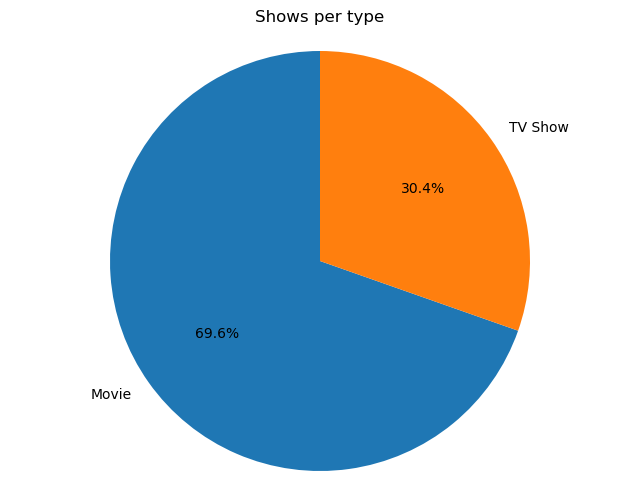

In [358]:
show_count_by_type = netflix.groupby('type')['show_id'].count()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(show_count_by_type, labels=show_count_by_type.index, autopct='%1.1f%%', startangle=90)
plt.title('Shows per type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


# Movie/Show Tags
Explore Listed_In as tags of shows/movies. If a show/movie has multiple tags, it will be counted towards each. 

International movies is the most popular tag in the data. And most of the shows in the data were released in the 2010s. 

Horror, Faith and Thrillers in the past 4 decades have on average gotten 4-6% longer.

In [359]:
# Create a list of all unique tags
all_tags = netflix['tags'].explode().unique()
tag_shows = {tag: [] for tag in all_tags}
tag_counts = {tag: 0 for tag in all_tags}
tag_counts_by_decade1 = {tag: {} for tag in all_tags}

for index, row in netflix.iterrows():
    show = row['show_id']
    tags = row['tags'] 
    release_year = row['release_year']
    decade = str(release_year)[:3] + '0s'
    
    # Update the dictionary with the corresponding shows for each tag
    for tag in tags:
        if decade in tag_counts_by_decade1[tag]:
            tag_shows[tag].append(show)
            tag_counts[tag] += 1
            tag_counts_by_decade1[tag][decade] += 1 
        else:
            tag_counts_by_decade1[tag][decade] = 1
        

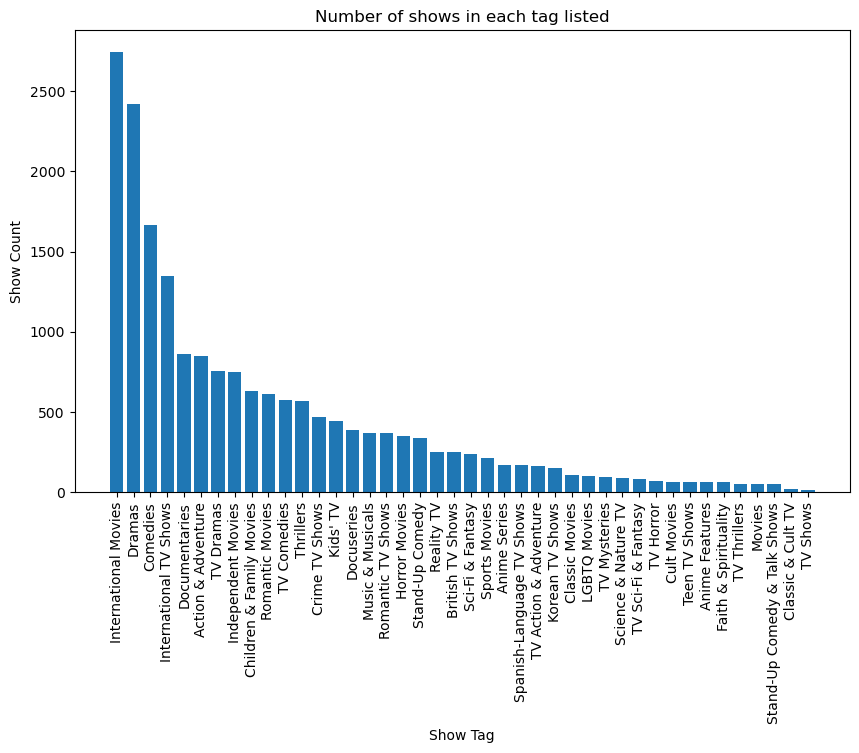

In [360]:
tag_counts_df = pd.DataFrame({'tag': list(tag_counts.keys()), 'count': list(tag_counts.values())})
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(tag_counts_df['tag'], tag_counts_df['count'])
plt.xlabel('Show Tag')
plt.ylabel('Show Count')
plt.title('Number of shows in each tag listed')
plt.xticks(rotation=90)
plt.show()

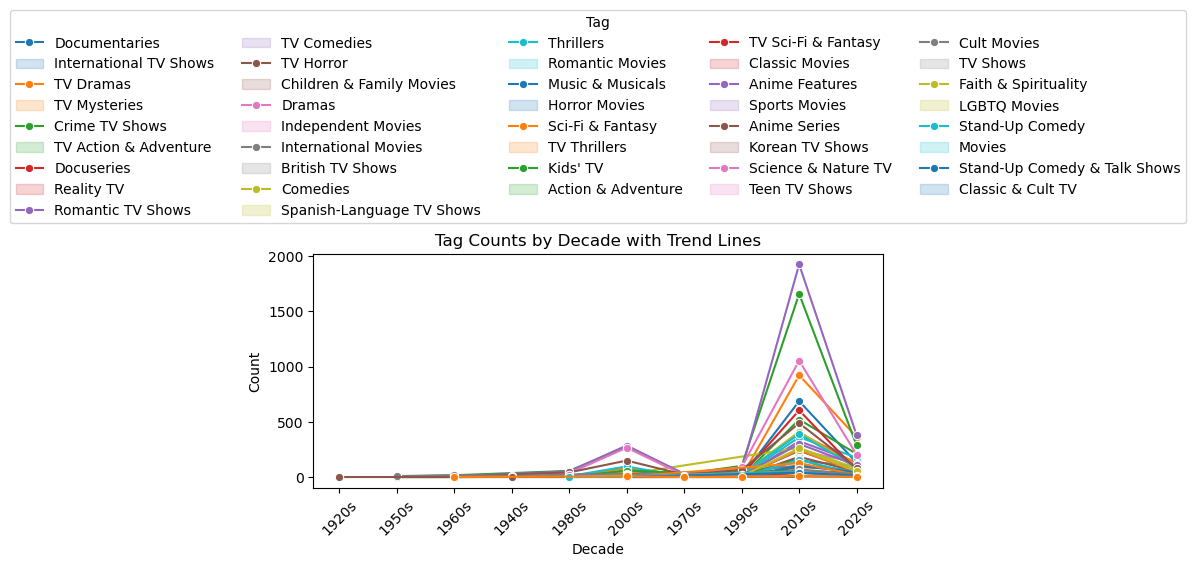

In [361]:
tag_counts_decade =  pd.DataFrame(tag_counts_by_decade1)


# Plot the bar chart with trend lines
plt.figure(figsize=(10, 6))
for tag in all_tags:
    sns.lineplot(data=tag_counts_decade[tag], marker='o')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Tag Counts by Decade with Trend Lines')
plt.gca().invert_xaxis()
plt.legend(all_tags, title='Tag', loc= 'lower center', bbox_to_anchor=(0.5, 1.1), ncol=5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [362]:
tag_counts_decade = tag_counts_decade.reindex(sorted(tag_counts_decade.index))
tag_counts_decade.index.name = 'decades'
tag_counts_decade.reset_index(inplace=True)

In [363]:
tag_counts_2010s = tag_counts_decade[tag_counts_decade['decades'] == '2010s']
tag_counts_2010s_numeric = tag_counts_2010s.apply(pd.to_numeric, errors='coerce')
max_count_2010s = tag_counts_2010s_numeric.select_dtypes(include=[np.number]).max().max() 
print("Maximum count across all tags in the 2010s:", max_count_2010s) 


# Find the location of the value where value == max_count_2010s
indices = np.where(tag_counts_2010s_numeric == max_count_2010s)
row_indices, col_indices = indices[0], indices[1]

print("In genre category (tag):")
for row, col in zip(row_indices, col_indices):
    column_name = tag_counts_2010s_numeric.columns[col]
    print(f"{column_name}")

Maximum count across all tags in the 2010s: 1923.0
In genre category (tag):
International Movies


In [364]:
movies = netflix[netflix['type'] == 'Movie']
all_movie_tags = movies['tags'].explode().unique()

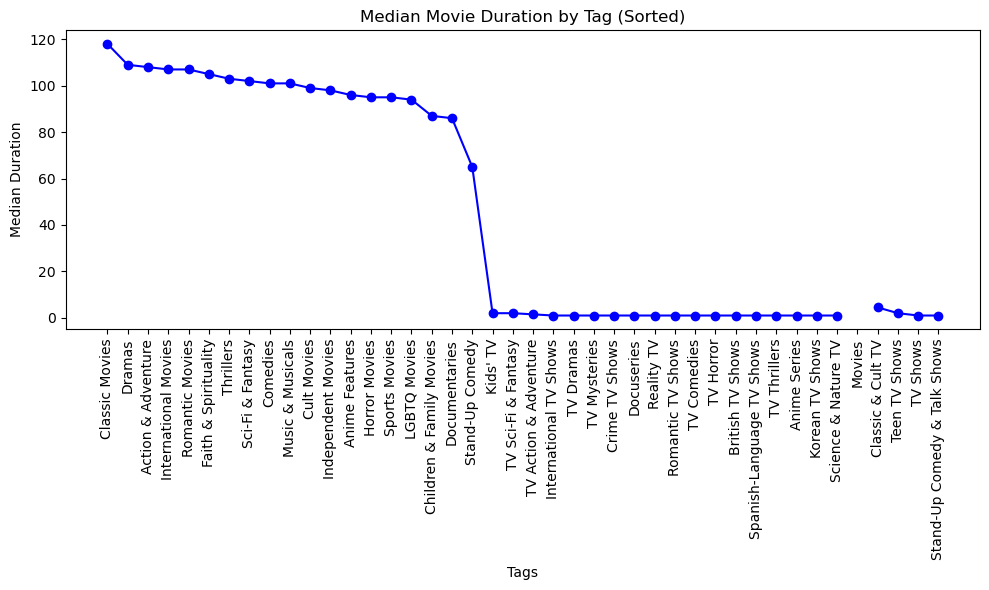

In [365]:
tag_shows = {tag: [] for tag in all_movie_tags}
tag_counts = {tag: 0 for tag in all_movie_tags}
tag_counts_by_decade1 = {tag: {} for tag in all_movie_tags}

tag_duration_stats = {}

for tag in all_tags:
    durations = netflix[netflix['tags'].apply(lambda x: tag in x)]['duration_num']
    median_duration = np.median(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)
    
    tag_duration_stats[tag] = {
        'median_duration': median_duration,
        'min_duration': min_duration,
        'max_duration': max_duration
    } 


# Create a list of tags and corresponding median durations
sorted_tags = sorted(tag_duration_stats.keys(), key=lambda tag: tag_duration_stats[tag]['median_duration'], reverse=True)
median_durations = [tag_duration_stats[tag]['median_duration'] for tag in sorted_tags]

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(sorted_tags, median_durations, marker='o', linestyle='-', color='blue')
plt.xlabel('Tags')
plt.ylabel('Median Duration')
plt.title('Median Movie Duration by Tag (Sorted)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

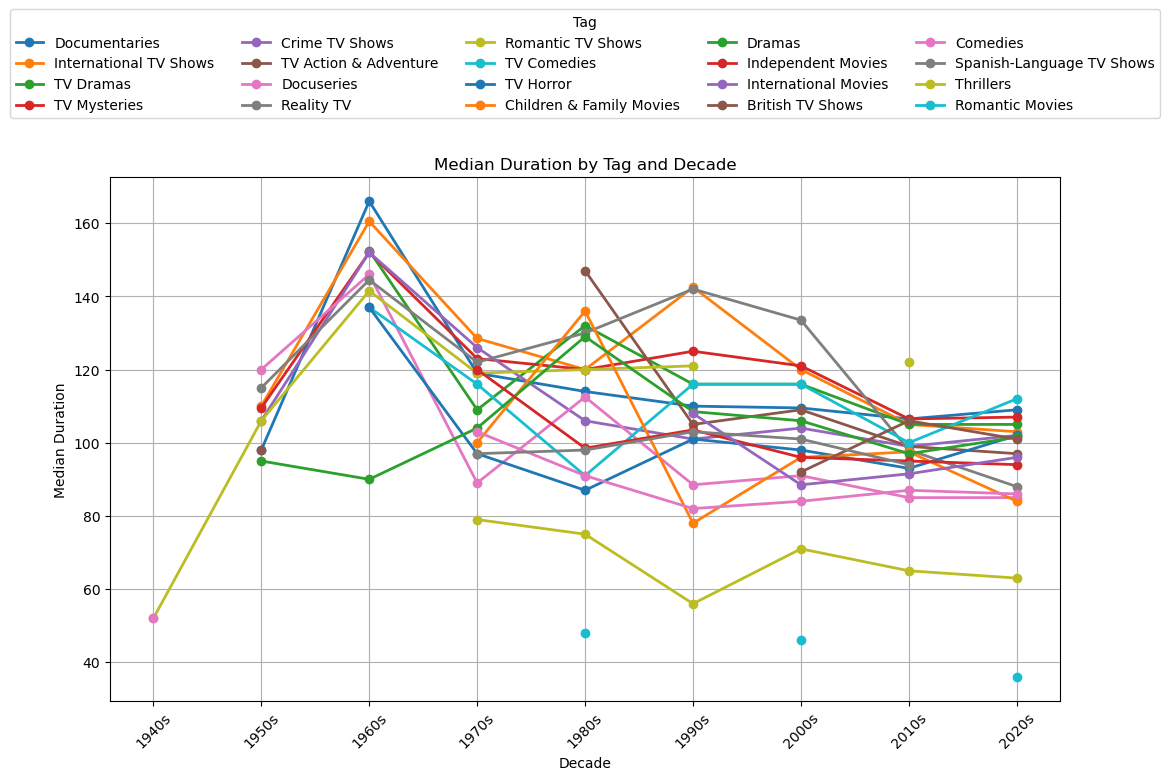

In [366]:

# Create a list of all unique tags 
tag_duration_stats = {tag: {'median_duration_by_decade': {}} for tag in all_tags}

for index, row in movies.iterrows():
    tags = row['tags']
    release_year = row['release_year']
    decade = str(release_year)[:3] + '0s'
    duration = row['duration_num']
    
    for tag in tags:
        if decade not in tag_duration_stats[tag]['median_duration_by_decade']:
            tag_duration_stats[tag]['median_duration_by_decade'][decade] = []
        tag_duration_stats[tag]['median_duration_by_decade'][decade].append(duration)

# Compute the median duration for each tag and decade
results=[]
for tag in all_movie_tags:
    for decade in tag_duration_stats[tag]['median_duration_by_decade']:
        median_duration = np.median(tag_duration_stats[tag]['median_duration_by_decade'][decade])
        tag_duration_stats[tag]['median_duration_by_decade'][decade] = median_duration
        results.append({'Tag': tag, 'Decade': decade, 'Median Duration': median_duration})

# Create a DataFrame from the results
movie_med_tag_decade_df = pd.DataFrame(results)

# Sort the tags based on the maximum median duration within each tag's dictionary
sorted_tags = sorted(all_movie_tags, key=lambda tag: max(tag_duration_stats[tag]['median_duration_by_decade'].values()), reverse=True)

# Get all unique decades in ascending order
sorted_decades = sorted(set(decade for tag in all_movie_tags for decade in tag_duration_stats[tag]['median_duration_by_decade']))

# Plot the median duration by tag and decade
plt.figure(figsize=(12, 8))
for tag in sorted_tags:
    median_durations = [tag_duration_stats[tag]['median_duration_by_decade'].get(decade, None) for decade in sorted_decades]
    plt.plot(sorted_decades, median_durations, marker='o', linestyle='-', linewidth=2, label=tag)

plt.xlabel('Decade')
plt.ylabel('Median Duration')
plt.title('Median Duration by Tag and Decade')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(all_tags, title='Tag', loc= 'lower center', bbox_to_anchor=(0.5, 1.1), ncol=5)
plt.tight_layout()
plt.show()



In [367]:
# Calculate decade-over-decade change in duration for each tag
change_results = []
for tag in all_tags:
    tag_data = movie_med_tag_decade_df[movie_med_tag_decade_df['Tag'] == tag]
    tag_data = tag_data.sort_values('Decade')
    
    for i in range(1, len(tag_data)):
        current_duration = tag_data.iloc[i]['Median Duration']
        previous_duration = tag_data.iloc[i-1]['Median Duration']
        decade_change_pct = round(100*(current_duration - previous_duration)/previous_duration, 2) 
        change_results.append({'Tag': tag, 'Decade': tag_data.iloc[i]['Decade'], 'Decade Pct Change': decade_change_pct})

# Create a DataFrame from the decade-over-decade change results
change_df = pd.DataFrame(change_results)
# Calculate average decade change per tag
# Filter records after the 1990s
filtered_change_df = change_df[change_df['Decade'] >= '1990s']

# Calculate average decade change per tag
average_change_df = filtered_change_df.groupby('Tag')['Decade Pct Change'].mean().reset_index()
average_change_df.sort_values('Decade Pct Change')

,Tag,Decade Pct Change
16,Sci-Fi & Fantasy,-8.987500
14,Music & Musicals,-8.387500
1,Anime Features,-7.965000
2,Children & Family Movies,-6.275000
10,Independent Movies,-5.510000
15,Romantic Movies,-5.400000
13,Movies,-4.170000
12,LGBTQ Movies,-3.250000
11,International Movies,-2.860000
7,Dramas,-2.635000


# Casts & Directors


Anupam Kher in 43 shows in the data. 

Top director-cast pairings are :


(director) Rajiv Chilaka with 

(cast) Rajesh Kava, Julie Tejwani, and Jigna Bhardwaj, having worked together on 17 shows.

In [ ]:
not_na_dir_mask = pd.notna(netflix['director'])
not_na_cast_mask =  pd.notna(netflix['cast'])
no_na_director = netflix[not_na_dir_mask]
relationship = no_na_director[not_na_cast_mask]
relationship.head()

In [383]:
# Create a list of all unique tags
all_cast_list = netflix['cast_list'].explode().unique()
cast_shows = {tag: [] for tag in all_cast_list}
cast_counts = {tag: 0 for tag in all_cast_list} 

for index, row in netflix.iterrows():
    show = row['show_id']
    tags = row['cast_list']
    if pd.Series(tags).notna().any():  # Check if any element in tags is not null or NaN
        tags = [tags] if isinstance(tags, str) else tags
        release_year = row['release_year']
        decade = str(release_year)[:3] + '0s'
        
        # Update the dictionary with the corresponding shows for each tag
        for tag in tags:
            cast_shows[tag].append(show)
            cast_counts[tag] += 1  

cast_counts_df = pd.DataFrame({'cast': list(cast_counts.keys()), 'show count': list(cast_counts.values())})
cast_counts_df = cast_counts_df.sort_values(by='show count', ascending=False) 

cast_counts_df 

,index,cast,show count
0,1434,Anupam Kher,43
1,783,Shah Rukh Khan,35
2,304,Julie Tejwani,33
3,1635,Naseeruddin Shah,32
4,4943,Takahiro Sakurai,32
...,...,...,...
36435,16389,Melanie Straub,1
36436,16387,Gabriela Maria Schmeide,1
36437,16385,Helena Zengel,1
36438,16384,Daniel Valenzuela,1


In [445]:
cast_member = "Anupam Kher"


# Filter the relationship DataFrame for the specified cast member
filtered_df = relationship[relationship['cast_list'].apply(lambda x: cast_member in x)]

# Group the filtered DataFrame by director and count the occurrences
director_counts = filtered_df['director'].value_counts().reset_index()
director_counts.columns = ['director', 'count']

# Print the director counts
director_counts.head(3)

,director,count
0,David Dhawan,6
1,Neeraj Pandey,3
2,Sooraj R. Barjatya,3


In [446]:
# Expand the cast_list column into individual cast members
expanded_relationship = relationship.explode('cast_list')

# Group the expanded_relationship DataFrame by director and cast member, and count the occurrences
pairing_counts = expanded_relationship.groupby(['director', 'cast_list']).size().reset_index(name='count')

# Sort the pairing_counts DataFrame by count in descending order
pairing_counts = pairing_counts.sort_values('count', ascending=False)

# Print the top 10 pairings
top_pairings = pairing_counts.head(10) 
top_pairings

,director,cast_list,count
31530,Rajiv Chilaka,Rajesh Kava,17
31524,Rajiv Chilaka,Julie Tejwani,17
31523,Rajiv Chilaka,Jigna Bhardwaj,17
31531,Rajiv Chilaka,Rupa Bhimani,16
31534,Rajiv Chilaka,Vatsal Dubey,15
31533,Rajiv Chilaka,Swapnil,12
31527,Rajiv Chilaka,Mousam,12
38526,Suhas Kadav,Saurav Chakraborty,8
40482,Toshiya Shinohara,Satsuki Yukino,7
34561,S.S. Rajamouli,Nassar,7


# Description - Setiment Analysis

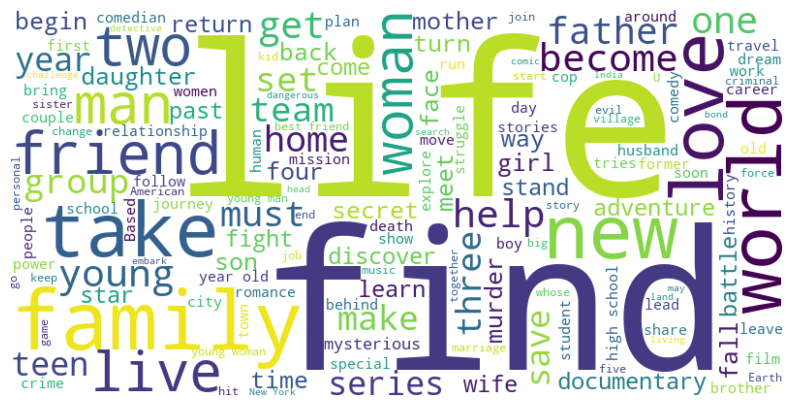

In [368]:


# Combine all descriptions into a single string
text = ' '.join(netflix['description'])

# Define a set of stopwords to exclude from the word cloud
stopwords = set(nltk.corpus.stopwords.words('english'))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white', stopwords=stopwords).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
 

In [447]:
#wordcloud per tag/genre
#
## Flatten the 'tags' column
#tags = list(itertools.chain.from_iterable(netflix['tags']))
#
## Get unique tags
#unique_tags = set(tags)
#
#for tag in unique_tags:
#    # Filter the dataframe to get descriptions for the current tag
#    descriptions = netflix[netflix['tags'].apply(lambda x: tag in x)]['description']
#    
#    # Combine all descriptions into a single string
#    text = ' '.join(descriptions)
#    
#    # Define a set of stopwords to exclude from the word cloud
#    stopwords = set(nltk.corpus.stopwords.words('english'))
#    
#    # Generate the word cloud
#    wordcloud = WordCloud(width=200, height=100, max_words=10, background_color='white', stopwords=stopwords).generate(text)
#    
#    # Plot the word cloud
#    plt.figure(figsize=(10, 6))
#    plt.imshow(wordcloud, interpolation='bilinear')
#    plt.title(f"Word Cloud for Tag: {tag}")
#    plt.axis('off')
#    plt.show()
#


In [370]:
#the SentimentIntensityAnalyzer (SIA) from NLTK calculates sentiment polarity using a lexicon-based approach. 
#It assigns sentiment scores to individual words and combines them to obtain an overall sentiment score for a given text. 
#The SIA returns four sentiment scores: positive, negative, neutral, and compound. 
#The positive, negative, and neutral scores represent the proportion of positive, negative, and neutral words in the text, respectively. 
#The compound score represents the overall sentiment polarity, ranging from -1 to 1, 
#where -1 indicates highly negative sentiment, 0 indicates neutral sentiment, 
#and 1 indicates highly positive sentiment
#

nltk.download('vader_lexicon')
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()
sentiment_scores = netflix['description'].apply(lambda x: sia.polarity_scores(x))

# Convert the sentiment scores into a DataFrame
sentiment_df = pd.DataFrame(sentiment_scores.tolist())

# Append the sentiment scores to the netflix DataFrame
netflix_with_sentiment = pd.concat([netflix, sentiment_df], axis=1)
netflix_with_sentiment = pd.DataFrame(netflix_with_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jlee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [371]:
#TextBlob calculates sentiment polarity using a combination of two metrics: 
#polarity and subjectivity. 
#The polarity score ranges from -1 to 1, 
#where -1 represents negative sentiment, 0 represents neutral sentiment, and 1 represents positive sentiment. 
#The subjectivity score ranges from 0 to 1, 
#where 0 represents objective content and 1 represents subjective content. 
#In TextBlob, the sentiment polarity is calculated based on the presence of positive and negative words in the text 
# and the overall subjectivity of the text.


# Function to calculate sentiment polarity using TextBlob
def get_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the 'description' column
netflix_with_sentiment['sentiment_polarity'] = netflix_with_sentiment['description'].apply(get_sentiment_polarity)


In [372]:
netflix_with_sentiment.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_num,tags,neg,neu,pos,compound,sentiment_polarity
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",90.0,[Documentaries],0.123,0.791,0.085,-0.2960,0.333333
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2.0,"[International TV Shows, TV Dramas, TV Mysteries]",0.118,0.786,0.096,-0.1531,0.000000
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,1.0,"[Crime TV Shows, International TV Shows, TV Ac...",0.306,0.546,0.148,-0.7783,-0.050000
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",1.0,"[Docuseries, Reality TV]",0.125,0.753,0.122,0.2263,-0.030505
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2.0,"[International TV Shows, Romantic TV Shows, TV...",0.000,0.769,0.231,0.7430,0.000000
